# Working with automated computations: Computed tables

Welcome back! In this session, we are going to continue working with the pipeline for the mouse electrophysiology example. 

In this session, we will learn to:

* compute various statistics for each neuron by defining a `Computed` table
* define a `Lookup` table to store parameters for computation
* define another `Computed` table to perform spike detection and store the detected spikes
* automatically trigger computations for all missing entries with `populate`
* define a `Part` table to save the results computed with the master `Computed` table

First thing first, let's import `datajoint` again.

In [1]:
import datajoint as dj

As we are going to perform some computations, let's go ahead and import NumPy as well as Matplotlib.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Similarly as before, to continue working with the tables we defined in the previous notebook, we can either redefine the classes for each table `Mouse`, `Session`, `Neuron` and populate them. Or, again for your convenience, we can import them from the `tutorial_pipeline.ephys_cell_activity` module. 

In [3]:
import os

if os.path.basename(os.getcwd()) != "notebooks":
    os.chdir("/home/notebooks")
from tutorial_pipeline.ephys_cell_activity import schema, Mouse, Session, Neuron

Please enter DataJoint username: root
Please enter DataJoint password: ········
Connecting root@localhost:3306
Populating neuron(s) for mouse_id=0 on session_date=2017-05-15
	Populated neuron 0
Populating neuron(s) for mouse_id=0 on session_date=2017-05-19
	Populated neuron 0
Populating neuron(s) for mouse_id=5 on session_date=2017-01-05
	Populated neuron 0
Populating neuron(s) for mouse_id=100 on session_date=2017-05-25
	Populated neuron 0
Populating neuron(s) for mouse_id=100 on session_date=2017-06-01
	Populated neuron 0


In [4]:
Session()

mouse_id Unique animal ID,session_date date,experiment_setup experiment setup ID,experimenter experimenter name,data_path
0,2017-05-15,0,Edgar Y. Walker,data
0,2017-05-19,0,Edgar Y. Walker,data
5,2017-01-05,1,Fabian Sinz,data
100,2017-05-25,100,Jacob Reimer,data
100,2017-06-01,1,Jacob Reimer,


In [5]:
Neuron()

mouse_id Unique animal ID,session_date date,neuron_id,activity electric activity of the neuron
0,2017-05-15,0,=BLOB=
0,2017-05-19,0,=BLOB=
5,2017-01-05,0,=BLOB=
100,2017-05-25,0,=BLOB=
100,2017-06-01,0,=BLOB=


The `ephys_cell_activity.py` also fills each table with data and import the neuron activity data from `.npy` files to make sure we are all on the same page.

## Computations in data pipeline

Now we have successfully imported all data we have into our pipeline, it's time for us to start analyzing them! 

When you perform computations in the DataJoint data pipeline, you focus and design tables in terms of **what** is it that you are computing rather than the **how**. You should think in terms of the "things" that you are computing!

Now, let's say that we want to compute the satististics, such as mean, standard deviation, and maximum value of each of our neuron's activity traces. Hence we want to compute the neuron's **activity statistics** for each neuron!

So the new "thing" or entity here is `ActivityStatistics`, where each entry corresponds to the statistics of a single `Neuron`. Let's start designing the table, paying special attention to the dependencies.

### Statistics of neuron activities

Before we create the table to store the statistics, let's think about how we might go about computing interesting statistics for a single neuron.

Let's start by fetching one neuron to work with.

In [6]:
keys = Neuron().fetch("KEY")

# pick one key
key = keys[0]

In [7]:
Neuron() & key

mouse_id Unique animal ID,session_date date,neuron_id,activity electric activity of the neuron
0,2017-05-15,0,=BLOB=


Lets go ahead and grab the `activity` data stored as numpy array. As we learned in the last session, we can `fetch` it!

In [8]:
activity = (Neuron() & key).fetch("activity")

In [9]:
activity

array([array([ 3.57887412e-01,  4.47531558e-01,  1.96412988e-01,  3.91114491e-01,
        1.76695176e-01,  3.80088116e-01,  9.36353656e-02,  1.10668001e-02,
        1.14509759e-01,  1.65947705e-01,  1.02058476e-01,  1.15037690e-01,
        2.18115225e-01,  1.34076355e-01,  7.74560696e-02,  9.19639027e-02,
       -7.60109670e-03,  1.12814011e+00,  9.48711628e-01,  7.77781245e-01,
        5.46847747e-01,  3.91930226e-01,  2.19542222e-01,  3.92001858e-01,
        3.17729202e-01,  2.97934834e-01,  1.85589403e-01,  3.04215179e-01,
        8.75626287e-02, -1.76018214e-02,  1.43719730e-01, -1.28348781e-01,
       -4.38344653e-02,  1.57370375e-01,  1.70233992e-01,  8.98556797e-01,
        9.36896773e-01,  1.67418776e+00,  2.48160598e+00,  1.89737445e+00,
        1.45746470e+00,  1.32137967e+00,  1.05349900e+00,  1.88503636e+00,
        1.53324759e+00,  1.34566597e+00,  1.93924029e+00,  1.58839106e+00,
        1.26074176e+00,  1.21973014e+00,  9.80495008e-01,  7.66163859e-01,
        1.59531686

It's a bit subtle, but `fetch` returns a NumPy array of the attribute, even if the attribute contains a NumPy array. So here, we actually got a NumPy array of NumPy array. We can of course just index into it,

In [10]:
activity[0]

array([ 3.57887412e-01,  4.47531558e-01,  1.96412988e-01,  3.91114491e-01,
        1.76695176e-01,  3.80088116e-01,  9.36353656e-02,  1.10668001e-02,
        1.14509759e-01,  1.65947705e-01,  1.02058476e-01,  1.15037690e-01,
        2.18115225e-01,  1.34076355e-01,  7.74560696e-02,  9.19639027e-02,
       -7.60109670e-03,  1.12814011e+00,  9.48711628e-01,  7.77781245e-01,
        5.46847747e-01,  3.91930226e-01,  2.19542222e-01,  3.92001858e-01,
        3.17729202e-01,  2.97934834e-01,  1.85589403e-01,  3.04215179e-01,
        8.75626287e-02, -1.76018214e-02,  1.43719730e-01, -1.28348781e-01,
       -4.38344653e-02,  1.57370375e-01,  1.70233992e-01,  8.98556797e-01,
        9.36896773e-01,  1.67418776e+00,  2.48160598e+00,  1.89737445e+00,
        1.45746470e+00,  1.32137967e+00,  1.05349900e+00,  1.88503636e+00,
        1.53324759e+00,  1.34566597e+00,  1.93924029e+00,  1.58839106e+00,
        1.26074176e+00,  1.21973014e+00,  9.80495008e-01,  7.66163859e-01,
        1.59531686e+00,  

but if we knew that there was only one item, we can use `fetch1` instead to save some trouble

In [11]:
activity = (Neuron() & key).fetch1("activity")

In [12]:
activity

array([ 3.57887412e-01,  4.47531558e-01,  1.96412988e-01,  3.91114491e-01,
        1.76695176e-01,  3.80088116e-01,  9.36353656e-02,  1.10668001e-02,
        1.14509759e-01,  1.65947705e-01,  1.02058476e-01,  1.15037690e-01,
        2.18115225e-01,  1.34076355e-01,  7.74560696e-02,  9.19639027e-02,
       -7.60109670e-03,  1.12814011e+00,  9.48711628e-01,  7.77781245e-01,
        5.46847747e-01,  3.91930226e-01,  2.19542222e-01,  3.92001858e-01,
        3.17729202e-01,  2.97934834e-01,  1.85589403e-01,  3.04215179e-01,
        8.75626287e-02, -1.76018214e-02,  1.43719730e-01, -1.28348781e-01,
       -4.38344653e-02,  1.57370375e-01,  1.70233992e-01,  8.98556797e-01,
        9.36896773e-01,  1.67418776e+00,  2.48160598e+00,  1.89737445e+00,
        1.45746470e+00,  1.32137967e+00,  1.05349900e+00,  1.88503636e+00,
        1.53324759e+00,  1.34566597e+00,  1.93924029e+00,  1.58839106e+00,
        1.26074176e+00,  1.21973014e+00,  9.80495008e-01,  7.66163859e-01,
        1.59531686e+00,  

Now we can compute some statistics:

In [13]:
# ENTER YOUR CODE! - compute the mean of the activity
mean_activity = activity.mean()
mean_activity

0.2073565345570553

In [14]:
# ENTER YOUR CODE! - compute the standard deviation of the activity
std_activity = activity.std()
std_activity

0.4008667662130083

In [15]:
# ENTER YOUR CODE! - compute the maximum of the activity
max_activity = activity.max()
max_activity

2.481605975684647

This gives us a good idea on how to:
1. fetch the activity of a neuron knowing its primary key, and
2. compute interesting statistics

Armed with this knowledge, let's go ahead and define the table for `ActivityStatistics`

### Defining `ActivityStatistics` table

Let's go ahead and work out the definition of the table.

In [16]:
@schema
class ActivityStatistics(dj.Computed):
    definition = """
    -> Neuron
    ---
    mean: float    # mean activity
    stdev: float   # standard deviation of activity
    max: float     # maximum activity
    """

Did you notice that we are now inheriting from `dj.Computed`?  `Computed` is yet another table tier that signifies that **the entries of this table are computed using data in other tables**. `Computed` tables are represented as red circles in the Diagram.

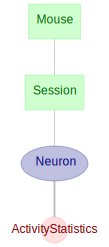

In [17]:
dj.Diagram(schema)

Just like the `Imported` tables, `Computed` tables make use of the same `make` and `populate` logic for defining new entries in the table. Let's go ahead and implement `make` method.

In [18]:
# ENTER YOUR CODE! - complete the `make` method


@schema
class ActivityStatistics(dj.Computed):
    definition = """
    -> Neuron
    ---
    mean: float    # mean activity
    stdev: float   # standard deviation of activity
    max: float     # maximum activity
    """

    def make(self, key):
        activity = (Neuron() & key).fetch1("activity")  # fetch activity as NumPy array

        # compute various statistics on activity
        key["mean"] = activity.mean()  # compute mean
        key["stdev"] = activity.std()  # compute standard deviation
        key["max"] = activity.max()  # compute max
        self.insert1(key)
        print(
            "Computed statistics for neuron_id {neuron_id} mouse_id {mouse_id} session_date {session_date}".format(
                **key
            )
        )

Let's go ahead and populate the table.

In [19]:
ActivityStatistics.populate()

Computed statistics for neuron_id 0 mouse_id 0 session_date 2017-05-15
Computed statistics for neuron_id 0 mouse_id 0 session_date 2017-05-19
Computed statistics for neuron_id 0 mouse_id 5 session_date 2017-01-05
Computed statistics for neuron_id 0 mouse_id 100 session_date 2017-05-25
Computed statistics for neuron_id 0 mouse_id 100 session_date 2017-06-01


In [20]:
ActivityStatistics()

mouse_id Unique animal ID,session_date date,neuron_id,mean mean activity,stdev standard deviation of activity,max maximum activity
0,2017-05-15,0,0.207357,0.400867,2.48161
0,2017-05-19,0,0.13274,0.291462,1.82805
5,2017-01-05,0,0.0891786,0.236412,1.37389
100,2017-05-25,0,0.21907,0.328783,1.76383
100,2017-06-01,0,0.0873266,0.237858,1.32454


Voila!! You have computed statistics for each neuron activity!

### Spike detection

Now, let's go ahead and tackle a more challenging computation. While having raw neural traces in itself can be quite interesting, nothing is as exciting as spikes! Let's take a look at the neurons activities and plot them.

In [21]:
# get all keys
keys = Neuron.fetch("KEY")

In [22]:
# fetch all activities - returned as NumPy array of NumPy arrays
activities = (Neuron & keys).fetch("activity")

In [23]:
fig, axs = plt.subplots(1, len(activities), figsize=(16, 4))
for activity, ax in zip(activities, axs.ravel()):
    ax.plot(activity)
    ax.set_xlabel("Time")
    ax.set_ylabel("Activity")

fig.tight_layout()

Let's now focus on one trace instead.

In [24]:
key = keys[0]

In [25]:
activity = (Neuron & key).fetch1("activity")

(0, 300)

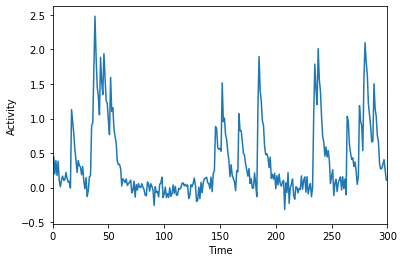

In [26]:
plt.plot(activity)
plt.xlabel("Time")
plt.ylabel("Activity")
plt.xlim([0, 300])

Perhaps we can use threshold to detect when a spike occurs. Threshold of `0.5` may be a good start.

In [27]:
threshold = 0.5

# find activity above threshold
above_thrs = (activity > threshold).astype(np.int)

plt.plot(activity)
plt.plot(above_thrs)
plt.xlabel("Time")
plt.xlim([0, 300])

(0, 300)

We want to find out **when** it crossed the threshold. That is, find time bins where `above_thrs` goes from 0 (`False`) to 1 (`True`).

(0, 300)

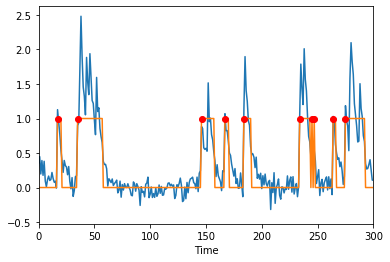

In [28]:
rising = (np.diff(above_thrs) > 0).astype(
    np.int
)  # find rising edge of crossing threshold
spikes = np.hstack((0, rising))  # prepend 0 to account for shortening due to np.diff

plt.plot(activity)
plt.plot(above_thrs)
plt.plot(np.where(spikes > 0), 1, "ro")
# plot only spike points
plt.xlabel("Time")
plt.xlim([0, 300])

Finally, let's also compute the spike counts

In [29]:
count = spikes.sum()  # compute total spike counts
count

26

Here is our complete spike detection algorithm:

In [30]:
# ENTER YOUR CODE! - try different values of threshold!

threshold = 0.7  # enter different threshold values here

# find activity above threshold
above_thrs = (activity > threshold).astype(np.int)

rising = (np.diff(above_thrs) > 0).astype(
    np.int
)  # find rising edge of crossing threshold
spikes = np.hstack((0, rising))  # prepend 0 to account for shortening due to np.diff

count = spikes.sum()  # compute total spike counts


plt.plot(activity)
plt.plot(above_thrs)
plt.plot(np.where(spikes > 0), 1, "ro")
# plot only spike points
plt.xlabel("Time")
plt.title("Total spike counts: {}".format(count));

Now notice that the exact spikes you detect depend on the value of the `threshold`. Therefore, the `threshold` is a parameter for our spike detection computation. Rather than fixing the value of the threshold, we might want to try different values and see what works well.

In other words, you want to compute `Spikes` for a **combination** of `Neuron`s and different `threshold` values. To do this while still taking advantage of the `make` and `populate` logic, you would want to define a table to house parameters for spike detection in a `Lookup` table!

## Parameter `Lookup` table

Let's define `SpikeDetectionParam` table to hold different parameter configuration for our spike detection algorithm. We are going to define this table as a `Lookup` table, rather than a `Manual` table. By now, you know that `Lookup` must be yet another **table tier** in DataJoint. `Lookup` tables are depicted by gray boxes in the Diagram.

This tier indicates that the table will contain information:
* that will be referenced by other tables
* that doesn't change much - usually contains a few pre-known entries

In [31]:
@schema
class SpikeDetectionParam(dj.Lookup):
    definition = """
    sdp_id: int      # unique id for spike detection parameter set
    ---
    threshold: float   # threshold for spike detection
    """

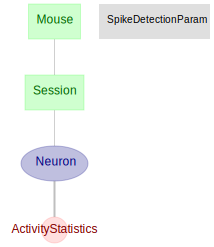

In [32]:
dj.Diagram(schema)

### Defining `Spikes` table

Now let's take everything together and define the `Spikes` table. Here each entry of the table will be *a set of spikes* for a single neuron, using a particular value of the `SpikeDetectionParam`. In other words, any particular entry of the `Spikes` table is determined by **a combination of a neuron and spike detection parameters**.

We capture this by depending on both `Neuron` and `SpikeDetectionParam`. For each spike set, we want to store the detected spikes and the total number of spikes. The table definition will look something like:

In [33]:
@schema
class Spikes(dj.Computed):
    definition = """
    -> Neuron
    -> SpikeDetectionParam
    ---
    spikes: longblob     # detected spikes
    count: int           # total number of detected spikes
    """

### Define the `Waveform` part table

We would also like to store the waveform at each detected spike, for a particular neuron. For simplicity, let's define the waveform to be 40 sample points before and after the onset of the detected spike. 
To accomplish this, we will define a `dj.Part` table `Waveform` which will contain the waveform per spike. The table definition is something like:

In [34]:
@schema
class Spikes(dj.Computed):
    definition = """
    -> Neuron
    -> SpikeDetectionParam
    ---
    spikes: longblob     # detected spikes
    count: int           # total number of detected spikes
    """

    class Waveform(dj.Part):
        definition = """
        -> master
        spike_id: int
        ---
        waveform: longblob  # waveform extracted from this spike
        """

The `-> master` syntax denotes that the `Waveform` part table is foreign key constrained by `Spike` table - i.e. the master table. The master table drives the ***populate*** logic, and the content of the part table is generally ingested together with the content of the master table, all in one step (i.e. one `make()` call).

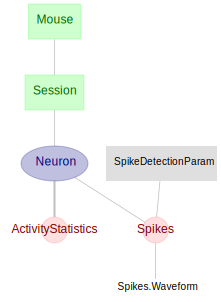

In [35]:
dj.Diagram(schema)

In the Diagram, we see that `Spikes` is a computed table (red circle) that depends on **both Neuron and SpikeDetectionParam**. Finally, let's go ahead and implement the `make` method for the `Spikes` table. 

In [36]:
@schema
class Spikes(dj.Computed):
    definition = """
    -> Neuron
    -> SpikeDetectionParam
    ---
    spikes: longblob     # detected spikes
    count: int           # total number of detected spikes
    """

    class Waveform(dj.Part):
        definition = """
        -> master
        spike_id: int
        ---
        waveform: longblob  # waveform extracted from this spike
        """

    def make(self, key):
        print("Populating for: ", key)

        activity = (Neuron() & key).fetch1("activity")
        threshold = (SpikeDetectionParam() & key).fetch1("threshold")

        above_thrs = (activity > threshold).astype(
            np.int
        )  # find activity above threshold
        rising = (np.diff(above_thrs) > 0).astype(
            np.int
        )  # find rising edge of crossing threshold
        spikes = np.hstack(
            (0, rising)
        )  # prepend 0 to account for shortening due to np.diff

        count = spikes.sum()  # compute total spike counts
        print("Detected {} spikes!\n".format(count))

        # create and insert a new dictionary containing `key` and additionally `spikes` and `count`
        self.insert1(dict(key, spikes=spikes, count=count))

        # extract waveform for the `Waveform` part-table
        before_spk, after_spk = (
            40,
            40,
        )  # extract 40 sample points before and after a spike as the waveform
        for spk_id, spk in enumerate(np.where(spikes == 1)[0]):
            # For simplicity, skip the spikes too close to the beginning or the end
            if spk - before_spk < 0 or spk + after_spk > len(activity) + 1:
                continue

            wf = activity[spk - before_spk : spk + after_spk]

            # create and insert a new dictionary containing `key` and additionally `spike_id` and `waveform`
            self.Waveform.insert1(dict(key, spike_id=spk_id, waveform=wf))

The implementation of the spike detection is pretty much what we had above, except that we now fetch the value of `threshold` from the `SpikeDetectionParam` table.

Looking at the `Spikes` table, we see that it indeed inherits the primary key attributes from **both Neuron (`mouse_id`, `session_date`) and SpikeDetectionParam (`sdp_id`)**.

In [37]:
Spikes()

mouse_id Unique animal ID,session_date date,neuron_id,sdp_id unique id for spike detection parameter set,spikes detected spikes,count total number of detected spikes


### Populating `Spikes` table

We are now ready to populate! When we call `populate` on `Spikes`, DataJoint will automatically call `make` on **every valid combination of the parent tables - Neuron and SpikeDetectionParam**.

In [38]:
# ENTER YOUR CODE! - populate the Spikes table
Spikes.populate()

Hm... `populate` doesn't seem to be doing anything... What could be the cause?

Looking at `SpikeDetectionParam` reveals the issue:

In [39]:
SpikeDetectionParam()

sdp_id unique id for spike detection parameter set,threshold threshold for spike detection


That's right! We have not added a detection parameter set yet. Let's go ahead and add one.

In [40]:
SpikeDetectionParam.insert1((0, 0.5))

In [41]:
SpikeDetectionParam()

sdp_id unique id for spike detection parameter set,threshold threshold for spike detection
0,0.5


Now we should really be ready to perform the computation...

In [42]:
# ENTER YOUR CODE! - populate the Spikes table for real!
Spikes.populate()

Populating for:  {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 15), 'neuron_id': 0, 'sdp_id': 0}
Detected 26 spikes!

Populating for:  {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 19), 'neuron_id': 0, 'sdp_id': 0}
Detected 24 spikes!

Populating for:  {'mouse_id': 5, 'session_date': datetime.date(2017, 1, 5), 'neuron_id': 0, 'sdp_id': 0}
Detected 18 spikes!

Populating for:  {'mouse_id': 100, 'session_date': datetime.date(2017, 5, 25), 'neuron_id': 0, 'sdp_id': 0}
Detected 41 spikes!

Populating for:  {'mouse_id': 100, 'session_date': datetime.date(2017, 6, 1), 'neuron_id': 0, 'sdp_id': 0}
Detected 18 spikes!



In [43]:
Spikes()

mouse_id Unique animal ID,session_date date,neuron_id,sdp_id unique id for spike detection parameter set,spikes detected spikes,count total number of detected spikes
0,2017-05-15,0,0,=BLOB=,26
0,2017-05-19,0,0,=BLOB=,24
5,2017-01-05,0,0,=BLOB=,18
100,2017-05-25,0,0,=BLOB=,41
100,2017-06-01,0,0,=BLOB=,18


...and we now have spike detection running!

Checking the waveform(s) from the Waveform part table

In [44]:
# ENTER YOUR CODE! - Now, build a query for the waveforms from mouse 100, session on "2017-05-25", with detection param 0
Spikes.Waveform & "mouse_id = 100" & 'session_date = "2017-05-25"' & "sdp_id = 0"

mouse_id Unique animal ID,session_date date,neuron_id,sdp_id unique id for spike detection parameter set,spike_id,waveform waveform extracted from this spike
100,2017-05-25,0,0,2,=BLOB=
100,2017-05-25,0,0,3,=BLOB=
100,2017-05-25,0,0,4,=BLOB=
100,2017-05-25,0,0,5,=BLOB=
100,2017-05-25,0,0,6,=BLOB=
100,2017-05-25,0,0,7,=BLOB=
100,2017-05-25,0,0,8,=BLOB=
100,2017-05-25,0,0,9,=BLOB=
100,2017-05-25,0,0,10,=BLOB=
100,2017-05-25,0,0,11,=BLOB=


In [45]:
# ENTER YOUR CODE! - try fetching all the waveforms
waveforms = (
    Spikes.Waveform & "mouse_id = 100" & 'session_date = "2017-05-25"' & "sdp_id = 0"
).fetch("waveform")

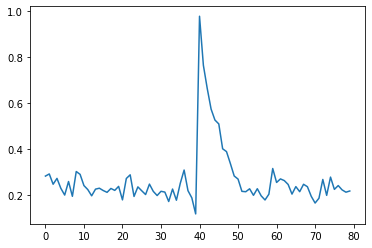

In [46]:
# ENTER YOUR CODE! - and plot the average waveform
plt.plot(waveforms.mean(axis=0))

### Trying out other parameter values

Let's see how different thresholds affect the results.

In [47]:
SpikeDetectionParam.insert1((1, 0.9))  # add another threshold

In [48]:
SpikeDetectionParam()

sdp_id unique id for spike detection parameter set,threshold threshold for spike detection
0,0.5
1,0.9


In [49]:
# ENTER YOUR CODE! - populate the "missing" entry in Spikes table
Spikes.populate()

Populating for:  {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 15), 'neuron_id': 0, 'sdp_id': 1}
Detected 27 spikes!

Populating for:  {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 19), 'neuron_id': 0, 'sdp_id': 1}
Detected 21 spikes!

Populating for:  {'mouse_id': 5, 'session_date': datetime.date(2017, 1, 5), 'neuron_id': 0, 'sdp_id': 1}
Detected 14 spikes!

Populating for:  {'mouse_id': 100, 'session_date': datetime.date(2017, 5, 25), 'neuron_id': 0, 'sdp_id': 1}
Detected 35 spikes!

Populating for:  {'mouse_id': 100, 'session_date': datetime.date(2017, 6, 1), 'neuron_id': 0, 'sdp_id': 1}
Detected 15 spikes!



In [50]:
Spikes()

mouse_id Unique animal ID,session_date date,neuron_id,sdp_id unique id for spike detection parameter set,spikes detected spikes,count total number of detected spikes
0,2017-05-15,0,0,=BLOB=,26
0,2017-05-15,0,1,=BLOB=,27
0,2017-05-19,0,0,=BLOB=,24
0,2017-05-19,0,1,=BLOB=,21
5,2017-01-05,0,0,=BLOB=,18
5,2017-01-05,0,1,=BLOB=,14
100,2017-05-25,0,0,=BLOB=,41
100,2017-05-25,0,1,=BLOB=,35
100,2017-06-01,0,0,=BLOB=,18
100,2017-06-01,0,1,=BLOB=,15


You can see that the results of spike detection under different parameter settings can live happily next to each other, without any confusion as to what is what.

## Deleting entries "upstream"

Now let's say that we decided that we don't like the first spike threshold of `0.5`. While there is really nothing wrong keeping those results around, you might decide that you'd rather delete all computations performed with that threshold to keep your tables clean.

While you can restrict `Spikes` table to the specific parameter id (i.e. `sdp_id = 0`) and delete the entries:

In [51]:
(Spikes & "sdp_id = 0").delete()

About to delete:
`root_tutorial_pipeline`.`__spikes__waveform`: 115 items
`root_tutorial_pipeline`.`__spikes`: 5 items
Proceed? [yes, No]: no
Cancelled deletes.


We can simply delete the unwanted parameter from the `SpikeDetectionParam` table, and let DataJoint cascade the deletion:

In [52]:
SpikeDetectionParam() & "sdp_id = 0"

sdp_id unique id for spike detection parameter set,threshold threshold for spike detection
0,0.5


In [53]:
(SpikeDetectionParam() & "sdp_id = 0").delete()

About to delete:
`root_tutorial_pipeline`.`__spikes__waveform`: 115 items
`root_tutorial_pipeline`.`__spikes`: 5 items
`root_tutorial_pipeline`.`#spike_detection_param`: 1 items
Proceed? [yes, No]: yes
Committed.


In [54]:
Spikes()

mouse_id Unique animal ID,session_date date,neuron_id,sdp_id unique id for spike detection parameter set,spikes detected spikes,count total number of detected spikes
0,2017-05-15,0,1,=BLOB=,27
0,2017-05-19,0,1,=BLOB=,21
5,2017-01-05,0,1,=BLOB=,14
100,2017-05-25,0,1,=BLOB=,35
100,2017-06-01,0,1,=BLOB=,15


## Summary

Congratulations! You have successfully extended your pipeline with a table to represent recorded data (`Neuron` as `Imported` table), tables that performs and represents computation results (`ActivityStatistics` and `Spikes` as `Computed` tables) and a table to hold computation parameters (`SpikeDetectionParam` as `Lookup` table).

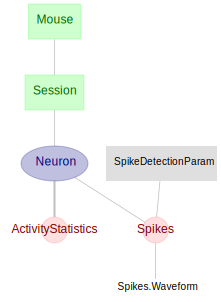

In [55]:
dj.Diagram(schema)

Our pipeline is still fairly simple but completely capable of handling analysis!